In [1]:
#Parallel computing settings to use 16CPUs

Parallelism().set('tensor', nproc=16)
Parallelism().set(nproc=16)
Parallelism()

Number of processes for parallelization:
 - linbox computations: 16
 - tensor computations: 16

In [2]:
#All needed packages

import numpy as np
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import time

In [3]:
#Parameters

e1 = 1/3
e2 = 1/3

l1 = 1/4
l2 = 3/5

fi = 0

#Renaming one of the rings. Otherwise, we get SageMath and Python syntax clash.
T = QQ[i]

In [4]:
#Describing all the variables which will be used in calculations.

z = var('z')
x,y = var('x,y',domain='complex')
xs,ys = var('x,y',domain='real')
mu = var('mu',domain='complex')

In [5]:
#Sets of equations as seen in the theory

#Zetas

zeta = x + I*y
zeta_bar = x - I*y

#I here denotes a square root of -1, bar stands for conjugates

In [6]:
#Lenses equation
z_bar(z) = zeta_bar + e1/(z-l1*exp(I*fi)) + e2/(z+l1*exp(I*fi)) + (1-e1-e2)/(z-l2)
L(z) = zeta -z + e1/(z_bar(z)-l1*exp(-I*fi)) + e2/(z_bar(z)+l1*exp(-I*fi)) + (1-e1-e2)/(z_bar(z)-l2)

#Leaving just the numerator
exp1 = L(z).numerator(normalize=true)

In [7]:
#Magnification
derivative_z(z) = e1/(z_bar(z)-l1*exp(-I*fi))^2 + e2/(z_bar(z)+l1*exp(-I*fi))^2 + (1-e1-e2)/(z_bar(z)-l2)^2
derivative_z_bar(z) = e1/(z-l1*exp(I*fi))^2 + e2/(z+l1*exp(I*fi))^2 + (1-e1-e2)/(z-l2)^2

magnification(z) = mu*(1-derivative_z(z)*derivative_z_bar(z))-1

#Leaving just the numerator
exp2 = magnification(z).numerator(normalize=true)

In [8]:
#Function creating a resultant for a pair(x,y)
def resultant(xs,ys):
    
    temp1 = exp1.subs({x:xs,y:ys})
    temp2 = exp2.subs({x:xs,y:ys})
    
    QQI.<I> = T
    R.<mu> = QQI[]
    S.<z> = R[]

    poly1 = temp1.polynomial(None,ring=S)
    poly2 = temp2.polynomial(None,ring=S)

    poly3 = poly1.resultant(poly2)
    
    return poly3

In [9]:
#Function calculating magnification out of the resultant
def magn(xs,ys):
    
    roots = resultant(xs,ys).roots(ring=CC)
    mag = sum([abs(roots[k][0].n()) for k in range(len(roots))])
    
    return log(mag)

In [10]:
#An empty matrix for storing results
A = np.zeros([71,71])

In [11]:
# xs and ys lists. They need to be sorted and specific to store results in a matrix
x_list = []
y_list = []

for u in range(36):
    x_list.append(u/35)
    
for u in range(1,36):
    x_list.append(-u/35)
    
x_list.sort()

y_list = x_list

In [12]:
#Parallel computing loop for faster processing
start_time = time.time()

if __name__ == '__main__':
    pool_size = min(os.cpu_count(), len(x_list) * len(y_list))
    with ProcessPoolExecutor(max_workers=pool_size) as executor:
        # create mapping between the Future instance returned by submit and the original m, n indexes:
        futures = {executor.submit(magn, x_list[m], y_list[n]): (m, n) for m in range(len(x_list)) for n in range(len(y_list))}
        for future in as_completed(futures):
            m, n = futures[future] # original indexes
            result = future.result()
            A[m][n] = result

print("--- %s seconds ---" % (time.time() - start_time))

--- 3264.7851872444153 seconds ---


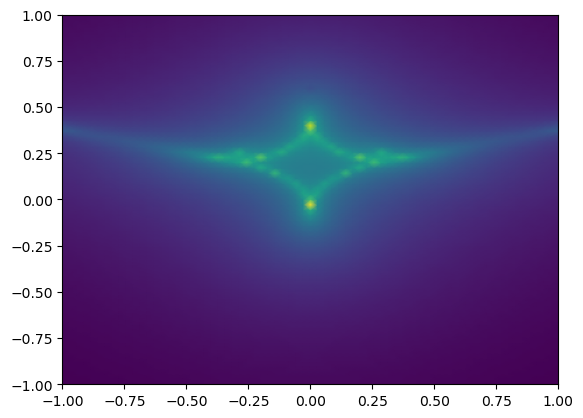

In [13]:
import matplotlib.pyplot as plt

#Subplots are needed for shadow
fig,ax = plt.subplots(1,1)

#Mapping a matrix and applying shadow based on lowest and highest value
ax.pcolormesh(y_list, x_list, A, shading='gouraud', vmin=A.min(), vmax=A.max())
plt.savefig('3lenses-l22.png')

In [14]:
m_line = []
for k in range(71):
    m_line.append(A[k,k])

In [15]:
len(x_list)

71

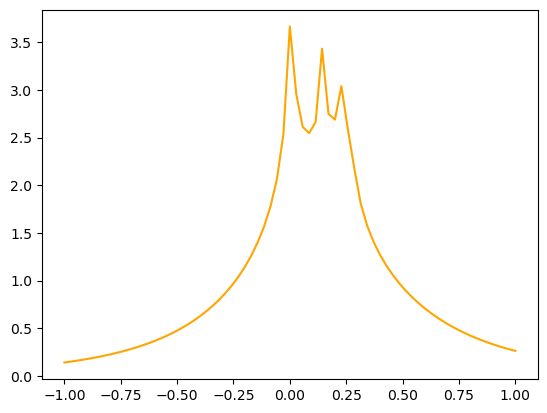

In [16]:
plt.plot(x_list,m_line,color='orange')
plt.savefig('3lenses-l22-lightcurves.png')